Set True to save the figures.

In [1]:
save = False

In [2]:
import numpy as np # scientific computing
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # reading images
from skimage.color import rgb2gray # converting rgb images to grayscale

Read images and convert them to grayscale.

In [3]:
img1 = rgb2gray(mpimg.imread('edge3.png'))

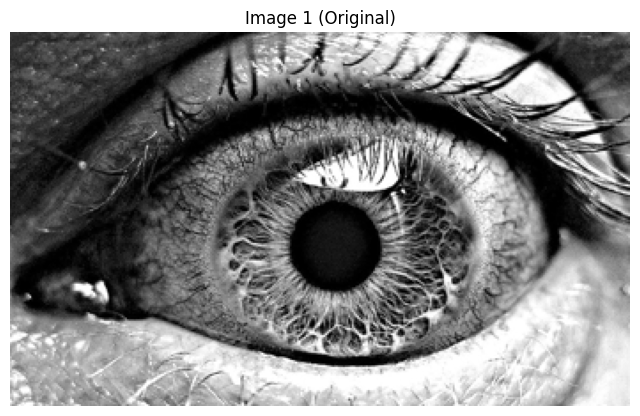

In [4]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Image 1 (Original)')
plt.imshow(img1, cmap='gray')
if save:
    plt.savefig('original1.png')
plt.show()

2D-convolution (actually cross-correlation)

In [5]:
def cross_correlate2D(img, mask):
    n_r, n_c = img.shape
    # Compute row and column offsets
    mask_r, mask_c = mask.shape
    r_offset = mask_r // 2 - (mask_r % 2 == 0)
    c_offset = mask_c // 2 - (mask_c % 2 == 0)
    # Apply zero-padding 
    padded_img = np.pad(img, ((r_offset, r_offset + (mask_r % 2 == 0)),
                              (c_offset, c_offset + (mask_c % 2 == 0))))
    # Perform 2D cross-correlation
    output = np.zeros((n_r, n_c))
    for row in range(r_offset, r_offset + n_r):
        for col in range(c_offset, c_offset + n_c):
            output[row - r_offset, col - c_offset] = np.sum(
                mask *
                padded_img[row - r_offset: row + r_offset + (mask_r % 2 == 0) + 1, 
                           col - c_offset: col + c_offset + (mask_c % 2 == 0) + 1]
            )
    return output

Sobel Operator:

In [6]:
def sobel(img):
    mask_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    mask_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    edge_x = cross_correlate2D(img, mask_x) / 6
    edge_y = cross_correlate2D(img, mask_y) / 6
    gradient_magnitudes = np.sqrt(edge_x ** 2 + edge_y ** 2)
    gradient_magnitudes *= 255 / np.max(gradient_magnitudes)
    gradient_directions = np.arctan2(edge_y, edge_x)
    return edge_x, edge_y, gradient_magnitudes, gradient_directions

Plotting code is refactored as a seperate function to avoid duplicate code. Feel free to change it.

In [7]:
def plot_results1(result1, result2, result3, result4, figsize_, titles, save=False, cmap4='viridis', dimension_x=2, dimension_y=2):
    fig, axs = plt.subplots(dimension_x, dimension_y, figsize=figsize_)
    
    indicies2x2 = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    if dimension_x==1 and dimension_y==2:
        for i in range(2):
            axs[i].set_title(titles[i])
            axs[i].axis('off')
            axs[i].imshow([result1, result2][i], cmap='gray')
    else:
        for i in range(4):
            axs[indicies2x2[i]].set_title(titles[i])
            axs[indicies2x2[i]].axis('off')
            axs[indicies2x2[i]].imshow([result1, result2, result3, result4][i], cmap=['gray', 'gray', 'gray', cmap4][i])
   
    if save:
        plt.savefig(method + '_results' + img_number + '.png')
    plt.show()

In [8]:
sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1 = sobel(img1)

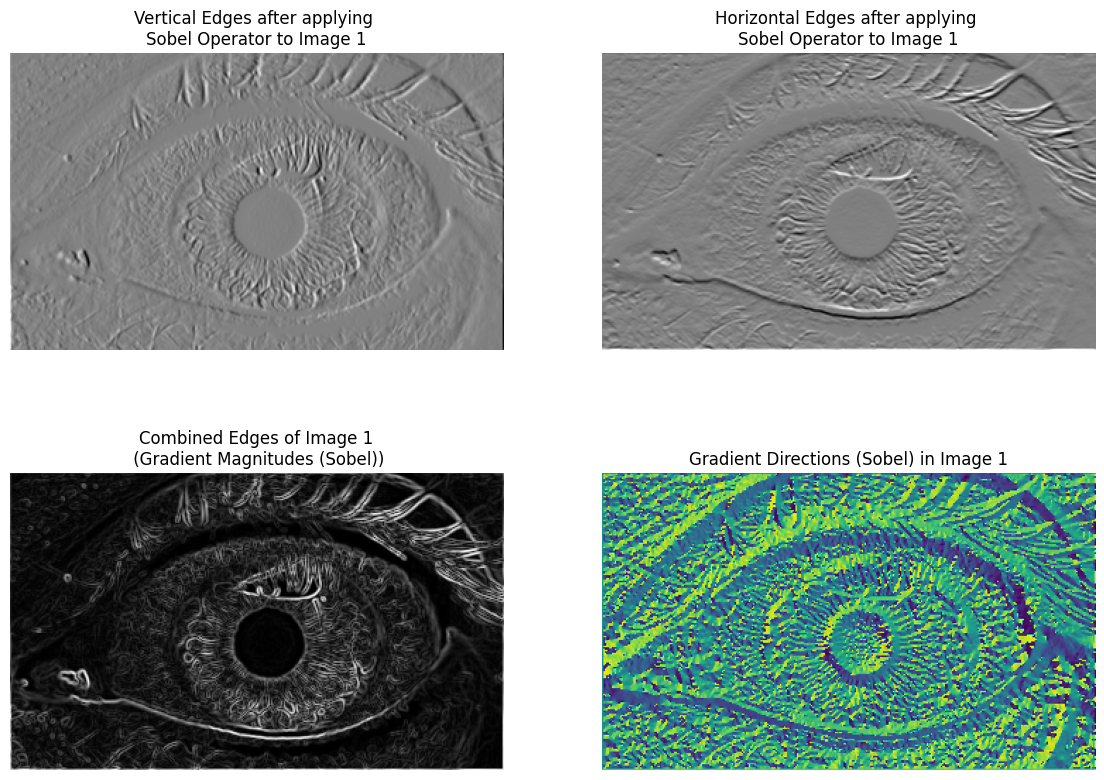

In [9]:
method = 'Sobel'
img_number = '1'
titles = ['Vertical Edges after applying \n' + method + ' Operator to Image ' + img_number,
          'Horizontal Edges after applying \n' + method + ' Operator to Image ' + img_number,
          'Combined Edges of Image ' + img_number + '\n (Gradient Magnitudes (' + method + '))',
          'Gradient Directions (' + method + ') in Image ' + img_number]
plot_results1(sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1, (14, 10), titles, save)

### Canny Edge Detector

**Step 1**: Apply Gaussian Blur to the image to reduce noise.

In [10]:
def gaussian_blur(sigma, k=2):
    """
    Generates a Gaussian Blur Filter with shape (2k + 1, 2k + 1), with
    the specified standard deviation.
    Args:
        sigma: The standard deviation of the Gaussian Blur
        k: The parameter that determines the shape of the filter (2 by default)
    Returns:
        G: The resulting Gaussian Blur Filter 
    """
    x, y = np.mgrid[-k: k + 1, -k: k + 1]
    G = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / 2 * np.pi * sigma ** 2
    return G

Plot a Gaussian Blur Filter of shape 11x11 and sigma 1 for illustration purposes

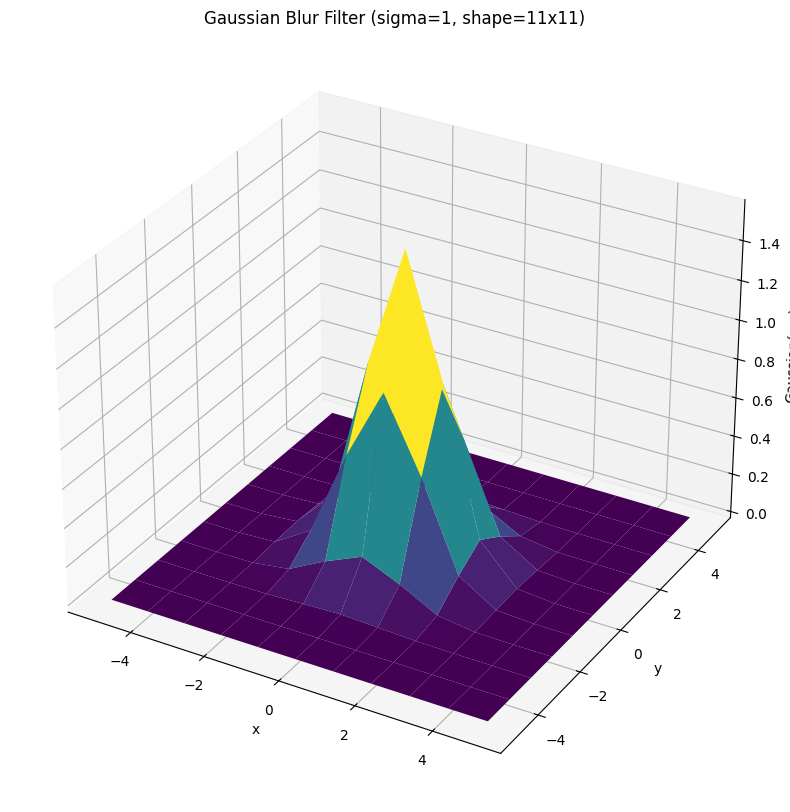

In [11]:
from mpl_toolkits import mplot3d # for 3D plotting

k_plt = 5
fig_3D = plt.figure(figsize=(15, 10))
ax_3D = plt.axes(projection='3d')
x_plt, y_plt = np.mgrid[-k_plt: k_plt + 1, -k_plt: k_plt + 1]
ax_3D.plot_surface(x_plt, y_plt, gaussian_blur(sigma=1, k=k_plt), rstride=1, cstride=1, 
                   cmap='viridis', edgecolor='none')
ax_3D.set_xlabel('x')
ax_3D.set_ylabel('y')
ax_3D.set_zlabel('Gaussian(x,y)')
plt.title('Gaussian Blur Filter (sigma=1, shape=11x11)')
#plt.savefig('gaussian_blur_3d.png')
plt.show()

**Step 2**: Gradient Calculation, use the **sobel** function implemented above for computing the graident magnitudes and directions. 

**Step 3**: Implement the Non-Maximum Suppression algorithm to thin out the detected edges.

In [12]:
def non_max_suppression(gradient_magnitudes, gradient_directions):
    """
    Implements the Non-Maximum Suppression algorithm to thin out the
    edges described as gradient magnitudes.
    Args:
        gradient_magnitudes: Edge intensities
        gradient_directions: Edge directions (angles in Radians)
    output:
        result: The processed edge intensities 
    """
   
    #INSER YOUR CODE HERE
    output = np.zeros_like(gradient_magnitudes)
    angle = np.degrees(gradient_directions)
    angle[angle < 0] += 180  # force angles into 4 sectors
    
    # Apply zero-padding to the gradient_magnitudes
    gradient_magnitudes1 = np.pad(gradient_magnitudes, 1, mode='constant')
       
    for i in range(1, gradient_magnitudes1.shape[0]-1):
        for j in range(1, gradient_magnitudes1.shape[1]-1):
            current_angle = angle[i-1, j-1]
            
            if (current_angle < 22.5) or (157.5 <= current_angle <= 180):
                before = gradient_magnitudes1[i, j-1]
                after = gradient_magnitudes1[i, j+1]
            elif (22.5 <= current_angle < 67.5):
                before = gradient_magnitudes1[i+1, j-1]
                after = gradient_magnitudes1[i-1, j+1]
            elif (67.5 <= current_angle < 112.5):
                before = gradient_magnitudes1[i-1, j]
                after = gradient_magnitudes1[i+1, j]
            elif (112.5 <= current_angle < 157.5):
                before = gradient_magnitudes1[i-1, j-1]
                after = gradient_magnitudes1[i+1, j+1]
            if (gradient_magnitudes1[i,j] >= before) and (gradient_magnitudes1[i,j] >= after):
                output[i-1,j-1] = gradient_magnitudes1[i,j]                    
    
    return output

**Step 4**: Implement the Double Thresholding algorithm to categorize pixels.

In [13]:
def double_threshold(img, ratio_low, ratio_high):
    """
    Categorizes the image pixels as strong, weak or non-edge
    using double thresholding, returns the thresholded image.
    Args:
        img: The input image
        ratio_low: The low threshold ratio 
        ratio_high: The high threshold ratio 
    Returns:
        thresholded_img: The thresholded output. Each pixel would take the value of 0, strong or weak intensities as set below. 
        weak: The intensity level of weak pixels
        strong: The intensity level of strong pixels
    """
    high = ratio_high * np.max(img)
    low = ratio_low * np.max(img)
    weak = 25
    strong = 255
    
    #INSER YOUR CODE HERE
    thresholded_img = np.zeros_like(img)
    
    thresholded_img[img >= low] = weak
    thresholded_img[img >= high] = strong

    return thresholded_img, weak, strong

**Step 5**: Implement Hysteresis to combine the Strong and Weak pixels and produces the final result. 

In [14]:
def hysteresis(img, weak, strong):
    """
    Args:
        img: The input image
        weak: The weak intensity level
        strong: The strong intensity level
    Returns:
        output: The processed output image
    """
    #INSER YOUR CODE HERE
    
    # starting from a strong pixel, mark all connected weak pixels as strong
    def bfsOnWeak(img, weak, strong, i, j):
        queue = [(i, j)]
        while queue:
            k, l = queue.pop()
            for m in range(-1, 2):
                for n in range(-1, 2):
                    if 0 <= k+m < img.shape[0] and 0 <= l+n < img.shape[1]:
                        if img[k+m, l+n] == weak:
                            img[k+m, l+n] = strong
                            queue.append((k+m, l+n))
    
    output = np.copy(img)
    
    # find weak edges connected to strong edges, and mark them as strong
    for i in range(1, output.shape[0]-1):
        for j in range(1, output.shape[1]-1):
            if output[i,j] == strong:
                bfsOnWeak(output, weak, strong, i, j)
                                    
    output[output != strong] = 0
    
    
    return output

Combine the five steps in a single algorithm:

In [15]:
def canny_edge_detector(img, sigma, ratio_low, ratio_high, k=2):
    """
    Applys Canny Edge Detection algorithm to a given image.
    Args:
        img: The input image
        sigma: The standard deviation of the 5x5 Gaussian Filter
           
        ratio_low: The low threshold ratio used in the Double Thresholding step
            
        ratio_high: The high threshold ratio used in the Double Thresholding step
            
        k: Parameter to adjust the shape of the (2k + 1, 2k + 1) gaussian blur 
    """
    G = gaussian_blur(sigma, k)
    blurred_img = cross_correlate2D(img, G)
    _, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
    nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)
    thresholded_img, weak, strong = double_threshold(nms_img, ratio_low, ratio_high)
    output = hysteresis(thresholded_img, weak, strong)
    return output

Add your results and answers to the questions 5.2.1, 5.2.2 and 5.2.3 here

### 5.2.1
#### edge1.png:
<img src="edge1.png" alt="edge1" height="250">

For Edge1.png, I chose the following parameters for the Canny edge detection algorithm:
- σ (Standard Deviation): 0.5
- Low Threshold Ratio: 0.03
- High Threshold Ratio: 0.15

I believe these parameters are best for this image because a low σ value minimizes blurring and preserves the thin lines of the tree branches and water current ripples on the beach, promoting good localization in smaller spots. The low ratio of 0.03 helps minimize false detection of small edges, while the high ratio of 0.15 preserves the linear structure of major edges in the image, such as the mountains, clouds, and horizon.

#### edge2.png:
<img src="edge2.png" alt="edge2" height="250">

For Edge2.png, I chose the following parameters for the Canny edge detection algorithm:
- σ (Standard Deviation): 0.4
- Low Threshold Ratio: 0.13
- High Threshold Ratio: 0.2

I believe these parameters are best for this image because I wanted to capture as much detail as possible in the edge detection without including the weak pixels, that would mean the details in the chairs, the change in flooring near plant, and the outlines behind the windows. With these parameters I maximized good detection and minimized the loss of accuracy finding as many edges as possible without including noise. I took specific thought about the uses of such an image, if I was asked, how many chairs are in this image, does each unit have ac units visible, are there railings guarding the upper floors, or other questions, this edge detection could answer it.

#### edge3.png:
<img src="edge3.png" alt="edge3" height="250">

For Edge3.png, I chose the following parameters for the Canny edge detection algorithm:
- σ (Standard Deviation): 0.7
- Low Threshold Ratio: 0.07
- High Threshold Ratio: 0.18

I believe these parameters are best for this image because the most important feature of this image is the details contained in the iris. A high sigma value would blur the central lines of the retina edges and reduce accuracy and a too low sigma would create false edges which would have enormously dangerous costs in a field like eye detection. My selected ratios for thresholding also play a major role in isolating only the important edges in the iris as well as keeping the details of the eyelashes.

### 5.2.2

#### edge1.png:

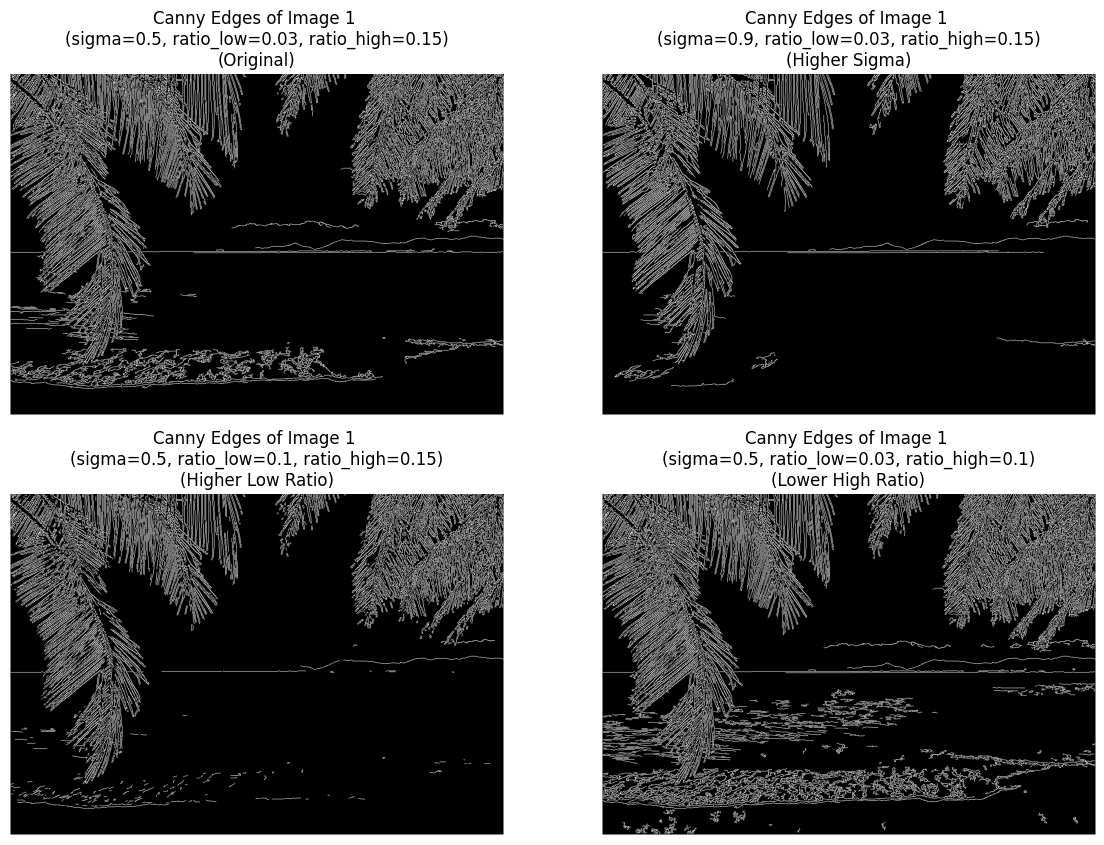

In [16]:
edge1 = rgb2gray(mpimg.imread('edge1.png'))
edge1_1 = canny_edge_detector(edge1, 0.5, 0.03, 0.15)
edge1_2 = canny_edge_detector(edge1, 0.9, 0.03, 0.15)
edge1_3 = canny_edge_detector(edge1, 0.5, 0.1, 0.15)
edge1_4 = canny_edge_detector(edge1, 0.5, 0.03, 0.1)
titles = ['Canny Edges of Image 1 \n(sigma=0.5, ratio_low=0.03, ratio_high=0.15)\n(Original)',
          'Canny Edges of Image 1 \n(sigma=0.9, ratio_low=0.03, ratio_high=0.15)\n(Higher Sigma)',
          'Canny Edges of Image 1 \n(sigma=0.5, ratio_low=0.1, ratio_high=0.15)\n(Higher Low Ratio)',
          'Canny Edges of Image 1 \n(sigma=0.5, ratio_low=0.03, ratio_high=0.1)\n(Lower High Ratio)']
plot_results1(edge1_1, edge1_2, edge1_3, edge1_4, (14, 10), titles, save, 'gray')

#### edge2.png:

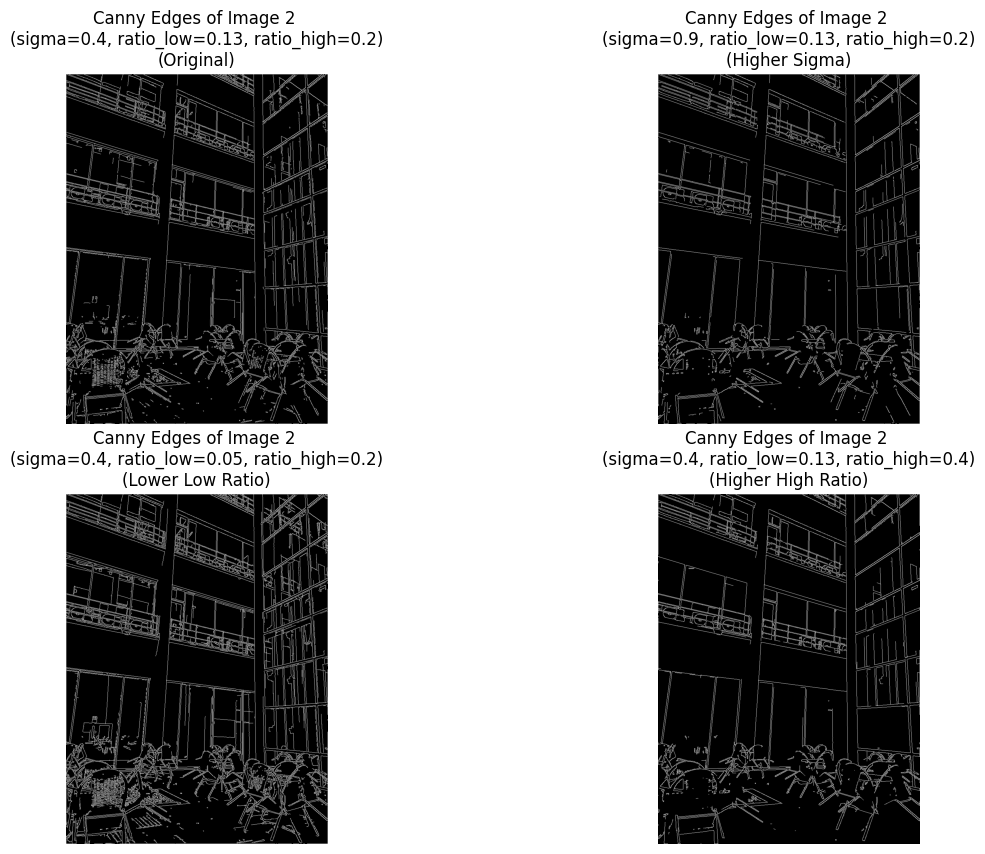

In [17]:
edge2 = rgb2gray(mpimg.imread('edge2.png')[..., :3])
edge2_1 = canny_edge_detector(edge2, 0.4, 0.13, 0.2)
edge2_2 = canny_edge_detector(edge2, 0.9, 0.13, 0.2)
edge2_3 = canny_edge_detector(edge2, 0.4, 0.05, 0.2)
edge2_4 = canny_edge_detector(edge2, 0.4, 0.13, 0.4)
titles = ['Canny Edges of Image 2 \n(sigma=0.4, ratio_low=0.13, ratio_high=0.2)\n(Original)',
          'Canny Edges of Image 2 \n(sigma=0.9, ratio_low=0.13, ratio_high=0.2)\n(Higher Sigma)',
          'Canny Edges of Image 2 \n(sigma=0.4, ratio_low=0.05, ratio_high=0.2)\n(Lower Low Ratio)',
          'Canny Edges of Image 2 \n(sigma=0.4, ratio_low=0.13, ratio_high=0.4)\n(Higher High Ratio)']
plot_results1(edge2_1, edge2_2, edge2_3, edge2_4, (14, 10), titles, save, 'gray')

#### edge3.png:

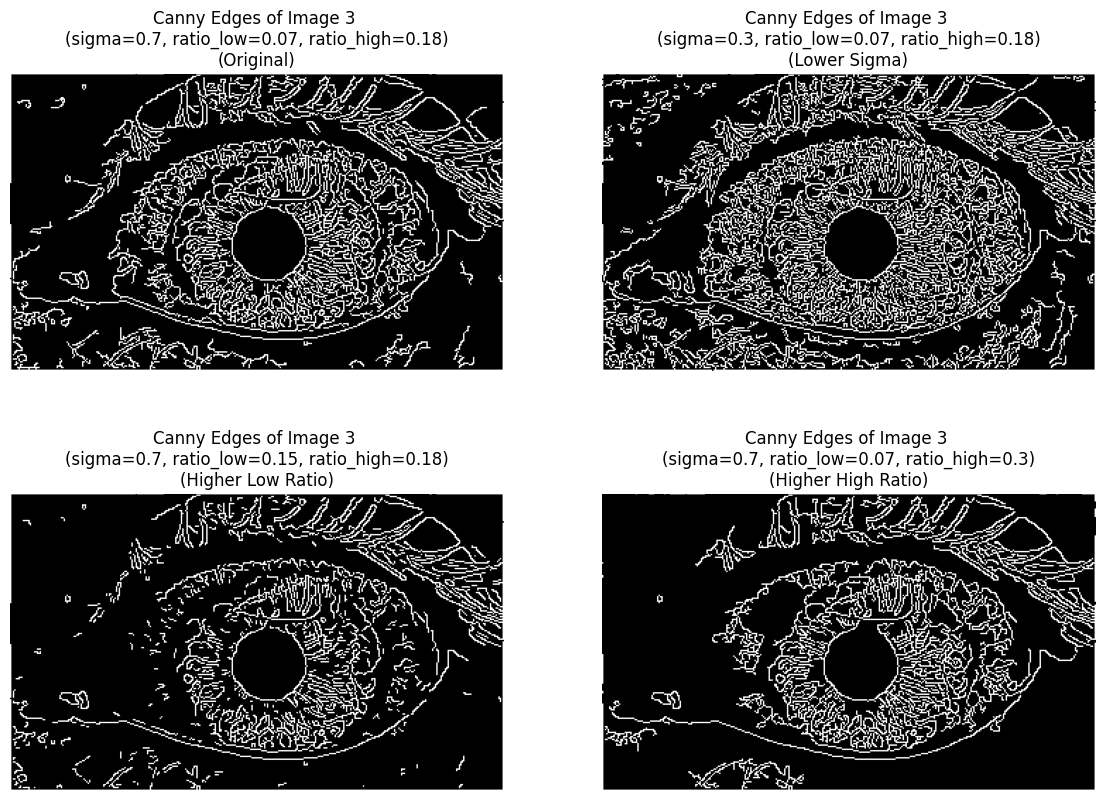

In [18]:
edge3 = rgb2gray(mpimg.imread('edge3.png'))
edge3_1 = canny_edge_detector(edge3, 0.7, 0.07, 0.18)
edge3_2 = canny_edge_detector(edge3, 0.3, 0.07, 0.18)
edge3_3 = canny_edge_detector(edge3, 0.7, 0.15, 0.18)
edge3_4 = canny_edge_detector(edge3, 0.7, 0.07, 0.3)
titles = ['Canny Edges of Image 3 \n(sigma=0.7, ratio_low=0.07, ratio_high=0.18)\n(Original)',
          'Canny Edges of Image 3 \n(sigma=0.3, ratio_low=0.07, ratio_high=0.18)\n(Lower Sigma)',
          'Canny Edges of Image 3 \n(sigma=0.7, ratio_low=0.15, ratio_high=0.18)\n(Higher Low Ratio)',
          'Canny Edges of Image 3 \n(sigma=0.7, ratio_low=0.07, ratio_high=0.3)\n(Higher High Ratio)']
plot_results1(edge3_1, edge3_2, edge3_3, edge3_4, (14, 10), titles, save, 'gray')

### 5.2.3

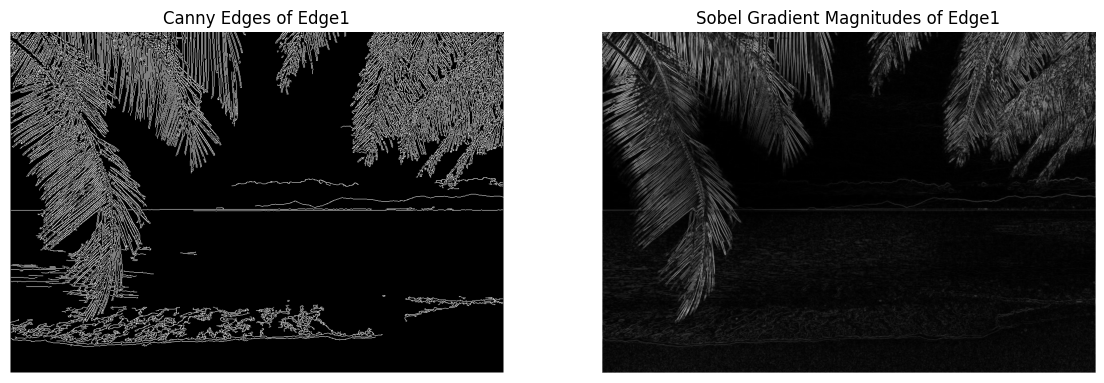

In [19]:
_, _, edge1_sobel_magnitudes, _ = sobel(edge1)
plot_results1(edge1_1, edge1_sobel_magnitudes, None, None, (14, 10), ['Canny Edges of Edge1', 'Sobel Gradient Magnitudes of Edge1'], save, 'gray', 1, 2)


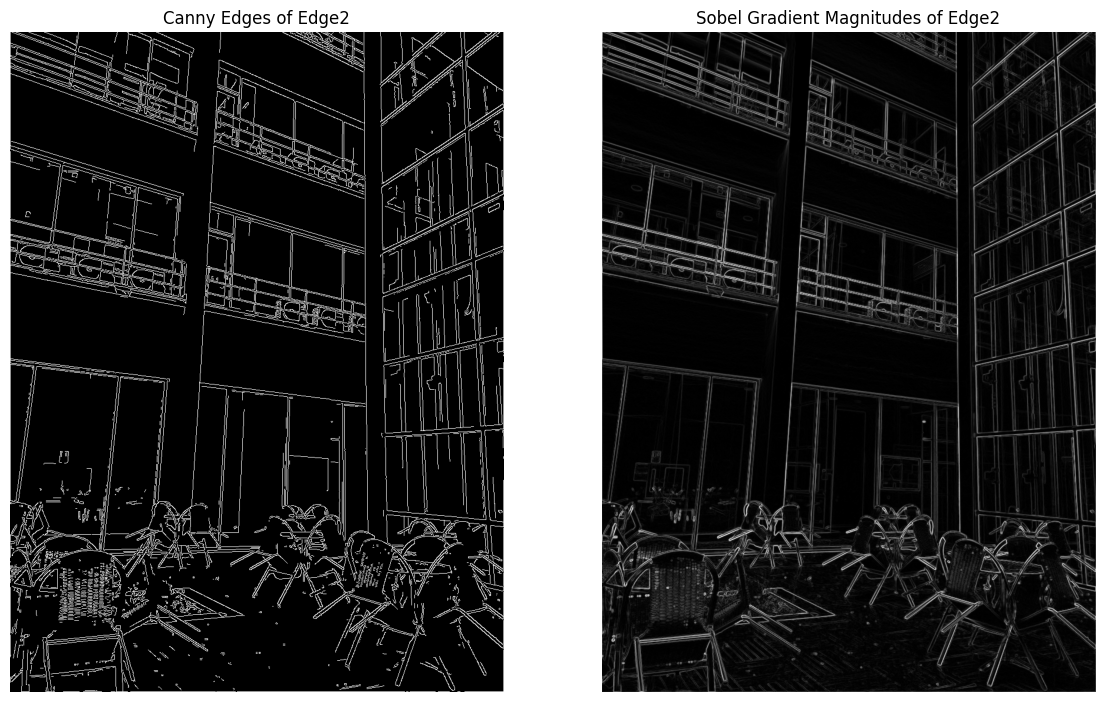

In [20]:
_, _, edge2_sobel_magnitudes, _ = sobel(edge2)
plot_results1(edge2_1, edge2_sobel_magnitudes, None, None, (14, 10), ['Canny Edges of Edge2', 'Sobel Gradient Magnitudes of Edge2'], save, 'gray', 1, 2)

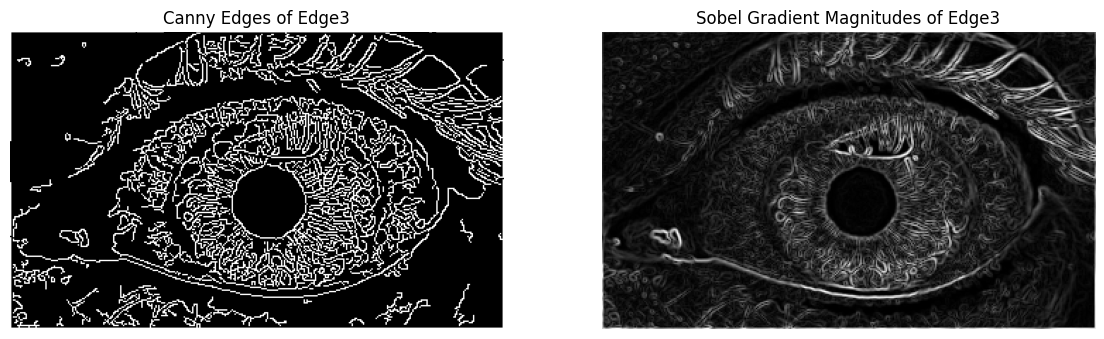

In [21]:
_, _, edge3_sobel_magnitudes, _ = sobel(edge3)
plot_results1(edge3_1, edge3_sobel_magnitudes, None, None, (14, 10), ['Canny Edges of Edge3', 'Sobel Gradient Magnitudes of Edge3'], save, 'gray', 1, 2)

#### Discussion
<!-- Explanation -->
Compared to the sobel images, the canny edge detection images, noticeably thins out edges, this is due to the non-maximum suppression algorithm which only keeps the max line in edges. It's also evident that the weak pixels not connected to the stronger edges in the image are removed, you can see this most clearly in edge1 and edge3, and this is due to both Double-Thresholding and hysteresis. Double-Thresholding labels the weak and strong points in the image and hysteresis only keeps the strong and the weak edges directly or indirectly connected to strong edges. Although not easily noticed, the blurring effect of the gaussian allows for easier detection of edges in the image.